Atividade final da disciplina de Visão Robótica

Discente: Henrique Antônio Guanais Corneau

# Reconstrução 3D a partir do mapa de disparidade

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

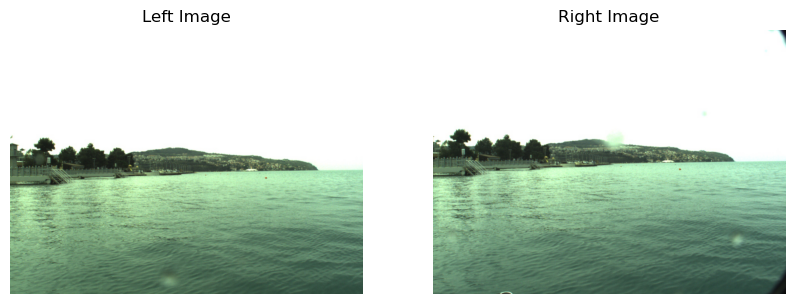

In [ ]:
# lista de imagens da camera ordenadas para a calibracao
left_images = sorted(glob.glob('..\\dataset\\MODD\\frames\\*L.jpg'))
right_images = sorted(glob.glob('..\\dataset\\MODD\\frames\\*R.jpg'))

left_images = [cv2.imread(img) for img in left_images]
right_images = [cv2.imread(img) for img in right_images]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_images[0], cv2.COLOR_BGR2RGB))
plt.title('Left Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_images[0], cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.axis('off')
plt.show()

In [3]:
# obter os parametros de calibracao da camera a partir do arquivo de calibracao
calibration_dir = "..\\dataset\\MODD\\calibration.yaml"
calibration_file = cv2.FileStorage(calibration_dir, cv2.FILE_STORAGE_READ)
Kl = np.array(calibration_file.getNode('M1').mat())
Dl = np.array(calibration_file.getNode('D1').mat())
Kr = np.array(calibration_file.getNode('M2').mat())
Dr = np.array(calibration_file.getNode('D2').mat())
R = np.array(calibration_file.getNode('R').mat())
T = np.array(calibration_file.getNode('T').mat())   
calibration_file.release()

print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[957.7950706    0.         656.23724898]
 [  0.         956.99355408 538.41903131]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-3.67679344e-01]
 [ 2.03381397e-01]
 [ 2.07905790e-04]
 [ 4.68656691e-04]
 [-7.56255767e-02]]
Right camera:
[[957.1114608    0.         641.71133185]
 [  0.         956.12071851 502.87401404]
 [  0.           0.           1.        ]]
Right camera distortion:
[[-3.66992989e-01]
 [ 2.05628665e-01]
 [ 2.41385031e-04]
 [-3.40254028e-04]
 [-7.92577706e-02]]
Rotation matrix:
[[ 9.99959238e-01  1.20322305e-04 -9.02818929e-03]
 [-8.24866241e-05  9.99991214e-01  4.19109356e-03]
 [ 9.02861425e-03 -4.19017801e-03  9.99950462e-01]]
Translation:
[[-356.38806655]
 [  -0.52120595]
 [  -2.66188526]]


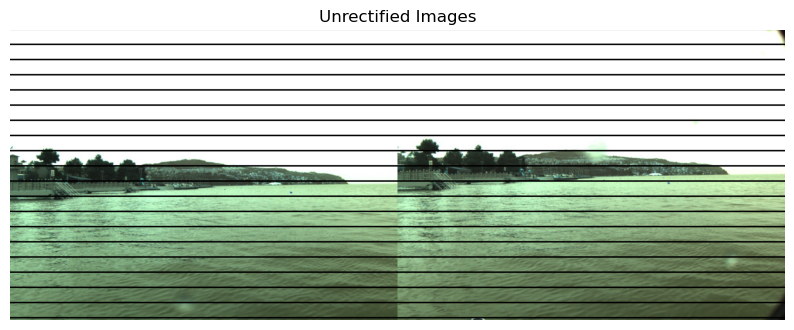

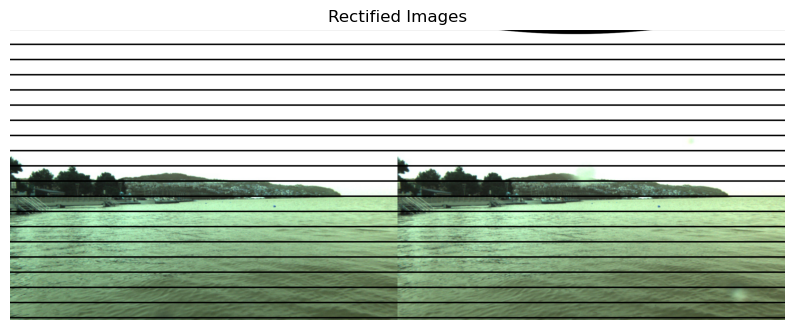

In [4]:
# Retificação estéreo
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(Kl, Dl, Kr, Dr, (left_images[0].shape[1], left_images[0].shape[0]), R, T)

# Mapas de remapeamento
map1_left, map2_left = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, (left_images[0].shape[1], left_images[0].shape[0]), cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, (right_images[0].shape[1], right_images[0].shape[0]), cv2.CV_32FC1)

# Aplicar remapeamento para retificar as imagens
rectified_left = [cv2.remap(img, map1_left, map2_left, cv2.INTER_LINEAR) for img in left_images]
rectified_right = [cv2.remap(img, map1_right, map2_right, cv2.INTER_LINEAR) for img in right_images]

# juntar as imagens normais e retificadas, para visualizacao
image_normal = np.hstack((left_images[0], right_images[0]))
image_combined = np.hstack((rectified_left[0], rectified_right[0]))

# desenhar as linhas epipolares
for i in range(0, image_combined.shape[1], 50):
    cv2.line(image_combined, (0, i), (image_combined.shape[1], i), (0, 0, 0), 4)
    cv2.line(image_normal, (0, i), (image_normal.shape[1], i), (0, 0, 0), 4)
    
plt.figure(figsize=(10, 5))
plt.imshow(image_normal, cmap='gray')
plt.title('Unrectified Images')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(image_combined, cmap='gray')
plt.title('Rectified Images')
plt.axis('off')
plt.show()


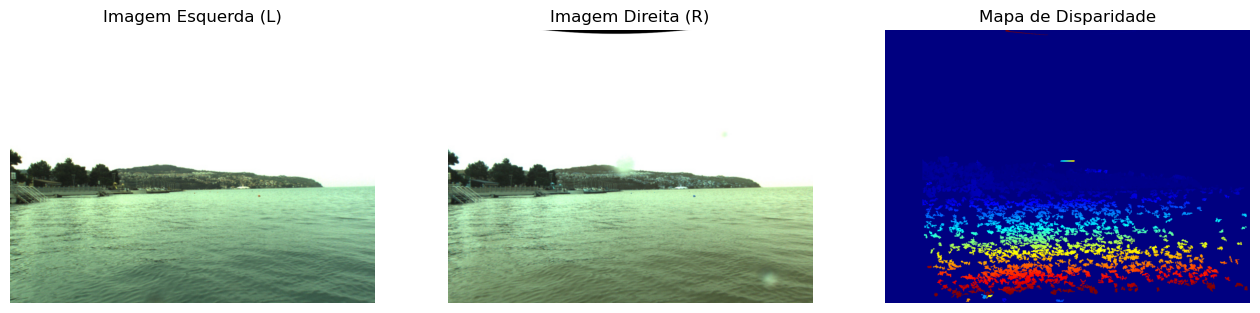

In [5]:
def load_stereo_params(stereo_method_file):
    '''
    Carrega os parâmetros do método estéreo

    Parâmetros:
        stereo_method_file: arquivo de parâmetros do método estéreo
    
    Retorna:
        stereo: objeto StereoBM com os parâmetros carregados
    '''
    cv_file = cv2.FileStorage(stereo_method_file, cv2.FILE_STORAGE_READ)
    if not cv_file.isOpened():
        print("Erro: Não foi possível abrir o arquivo de parâmetros estéreo.")
    else:
        # Extrair os parâmetros do método estéreo
        PreFilterType = int(cv_file.getNode("PreFilterType").real())
        PreFilterSize = int(cv_file.getNode("PreFilterSize").real())
        PreFilterCap = int(cv_file.getNode("PreFilterCap").real())
        SADWindowSize = int(cv_file.getNode("SADWindowSize").real())
        NumDisparities = int(cv_file.getNode("NumDisparities").real())
        TextureThreshold = int(cv_file.getNode("TextureThreshold").real())
        UniquenessRatio = int(cv_file.getNode("UniquenessRatio").real())
        SpeckleWindowSize = int(cv_file.getNode("SpeckleWindowSize").real())
        SpeckleRange = int(cv_file.getNode("SpeckleRange").real())
        Disp12MaxDiff = int(cv_file.getNode("Disp12MaxDiff").real())
        cv_file.release()

    # Configurar StereoBM usando parâmetros carregados
    stereo = cv2.StereoBM_create(
        numDisparities=NumDisparities,
        blockSize=SADWindowSize
    )

    # setar as configuracoes do StereoBM
    stereo.setPreFilterType(PreFilterType)
    stereo.setPreFilterSize(PreFilterSize)
    stereo.setPreFilterCap(PreFilterCap)
    stereo.setTextureThreshold(TextureThreshold)
    stereo.setUniquenessRatio(UniquenessRatio)
    stereo.setSpeckleWindowSize(SpeckleWindowSize)
    stereo.setSpeckleRange(SpeckleRange)
    stereo.setDisp12MaxDiff(Disp12MaxDiff)

    return stereo

stereo = load_stereo_params("..\\dataset\\MODD\\stereo-method.yaml")

depth_maps = []
# para cada imagem estereo, e criada uma imagem de disparidade
for imgL, imgR in zip(rectified_left, rectified_right):
    imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    disparity_map = stereo.compute(imgL_gray, imgR_gray).astype(np.float32)/16
    # o mapa e normalizado e aplicado cores para a visualizacao
    disparity_normalize = cv2.normalize(src=disparity_map, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    disparity_normalize = cv2.applyColorMap(disparity_normalize, cv2.COLORMAP_JET)
    # lista que contem todos os mapas criados
    depth_maps.append(disparity_normalize)

plt.figure(figsize=(16, 10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(rectified_left[0], cv2.COLOR_BGR2RGB))
plt.title("Imagem Esquerda (L)")
plt.axis('off')

plt.subplot(132)
plt.imshow(rectified_right[0], cmap='gray')
plt.title("Imagem Direita (R)")
plt.axis('off')

plt.subplot(133)
plt.imshow((cv2.cvtColor(depth_maps[0], cv2.COLOR_BGR2RGB)))
plt.title("Mapa de Disparidade")
plt.axis('off')
plt.show()

In [6]:
def create_output(vertices, colors, filename):
	"""
	Função que cria um arquivo .ply da nuvem de pontos.

	Parâmetros:	
		vertices: coordenadas 3D dos pontos
		colors: cor dos pontos
		filename: nome do arquivo .ply
	"""

	# redimensiona o vetor de cores e de pontos
	colors = colors.reshape(-1, 3)
	vertices = np.hstack([vertices.reshape(-1, 3), colors])
	# define o cabeçalho do arquivo .ply
	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	# escreve o arquivo .ply
	with open(filename, 'w') as f:
		f.write(ply_header % dict(vert_num=len(vertices)))
		np.savetxt(f, vertices, '%f %f %f %d %d %d')

In [ ]:
points, map_colors = [], []
for disparity_map in depth_maps:
    depth_map_gray = cv2.cvtColor(disparity_map, cv2.COLOR_BGR2GRAY)
    points_3D = cv2.reprojectImageTo3D(depth_map_gray, Q)

    # Remove INF values from point cloud
    points_3D[points_3D == float('+inf')] = 0
    points_3D[points_3D == float('-inf')] = 0

    # Get rid of points with value 0 (i.e no depth)
    mask_map = depth_map_gray > depth_map_gray.min()

    # Mask colors and points
    colors = cv2.cvtColor(left_images[0], cv2.COLOR_BGR2RGB)
    output_points = points_3D[mask_map]/1000
    output_colors = colors[mask_map]

    points.append(output_points)  
    map_colors.append(output_colors) 

In [8]:
# Converter para numpy arrays
points = np.vstack(points)  # Unir todas as listas em uma matriz 2D
map_colors = np.vstack(map_colors)  # Unir todas as listas de cores em uma matriz 2D
print(points.shape)
print(map_colors.shape)

# Generate point cloud
output_file = 'point_cloud1.ply'
create_output(points, map_colors, output_file)

(56391370, 3)
(56391370, 3)


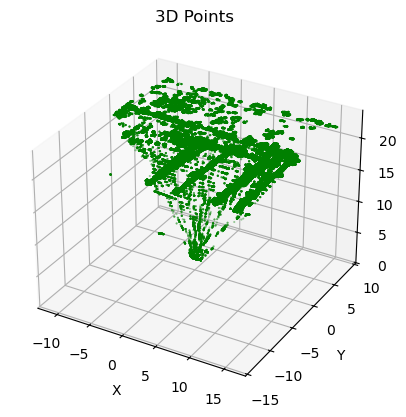

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], marker='.', s=1, c='g')
plt.title('3D Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()